# Context-wise disagreement and scatter view of model roles

This notebook visualizes the context-wise disagreement scores from Exp 7.

We focus on:
- How much each model disagrees with its peers in different semantic contexts,
- How these disagreements change between low and high masking doses,
- A 2D scatter view that highlights the role reversal between ALBERT and DistilBERT.


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (4.0, 3.0)
plt.rcParams["figure.dpi"] = 150
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.alpha"] = 0.3
plt.rcParams["font.size"] = 9
plt.rcParams["legend.frameon"] = False

FIG_PATH = "../results/figures"

csv_path = os.path.join("..", "results", "tables", "exp7_bert_context_disagreement.csv")
df = pd.read_csv(csv_path)

df.head()


,ContextType,ContextLabel,TargetModel,Dose,MeanDisagreement,StdDisagreement,NumPoints,ContextRawSize
0,length,len_long_(>15),BERT,0.0,0.156301,0.118986,200,561
1,length,len_long_(>15),BERT,0.1,0.164920,0.108937,200,561
2,length,len_long_(>15),BERT,0.2,0.182434,0.121824,200,561
3,length,len_long_(>15),BERT,0.3,0.255845,0.072204,200,561
4,length,len_long_(>15),BERT,0.4,0.274672,0.105487,200,561


In [2]:
print("Columns:", df.columns.tolist())
print()
print("Context types:", df["ContextType"].unique())
print()
print("Models:", df["TargetModel"].unique())
print()
print("Dose values:", sorted(df["Dose"].unique()))


Columns: ['ContextType', 'ContextLabel', 'TargetModel', 'Dose', 'MeanDisagreement', 'StdDisagreement', 'NumPoints', 'ContextRawSize']

Context types: ['length' 'sentiment' 'negation']

Models: ['BERT' 'DistilBERT' 'RoBERTa' 'ALBERT' 'XLNet']

Dose values: [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9]


## Derived features for scatter

We construct a simple 2D feature space for each model at the highest dose:

- **Δ_length** = D(long, max dose) − D(medium, max dose)  
  Positive values mean that the model disagrees more with its peers on long sentences than on medium-length sentences.

- **Δ_negation** = D(has_negation, max dose) − D(no_negation, max dose)  
  Positive values mean that the model disagrees more on sentences with explicit negation than on sentences without negation.

Each model is mapped to a point (Δ_length, Δ_negation).  
This 2D view highlights whether a model's uniqueness is amplified by difficulty factors such as length and negation.


In [3]:
def get_max_dose(df_in: pd.DataFrame) -> float:
    """Return the maximum dose present in the CSV."""
    return float(df_in["Dose"].max())


def context_mean_disagreement(
    df_in: pd.DataFrame,
    model_name: str,
    context_type: str,
    context_label: str,
    dose: float,
) -> float:
    """
    Return the mean disagreement for (model, context_type, context_label, dose),
    or NaN if there is no entry.
    """
    sub = df_in[
        (df_in["TargetModel"] == model_name)
        & (df_in["ContextType"] == context_type)
        & (df_in["ContextLabel"] == context_label)
        & (np.isclose(df_in["Dose"], dose))
    ]
    if sub.empty:
        return np.nan
    return float(sub["MeanDisagreement"].mean())


max_dose = get_max_dose(df)
print("Max dose for this experiment:", max_dose)

models = sorted(df["TargetModel"].unique())

# We assume context labels are the same as in Exp 6
length_long = "len_long_(>15)"
length_medium = "len_medium_(8-15)"
neg_has = "has_negation"
neg_no = "no_negation"

rows = []
for m in models:
    d_long = context_mean_disagreement(df, m, "length", length_long, max_dose)
    d_medium = context_mean_disagreement(df, m, "length", length_medium, max_dose)
    d_has = context_mean_disagreement(df, m, "negation", neg_has, max_dose)
    d_no = context_mean_disagreement(df, m, "negation", neg_no, max_dose)

    delta_len = d_long - d_medium
    delta_neg = d_has - d_no

    rows.append(
        {
            "TargetModel": m,
            "D_long": d_long,
            "D_medium": d_medium,
            "D_has_neg": d_has,
            "D_no_neg": d_no,
            "Delta_length": delta_len,
            "Delta_negation": delta_neg,
        }
    )

scatter_df = pd.DataFrame(rows)
scatter_df


Max dose for this experiment: 0.9


,TargetModel,D_long,D_medium,D_has_neg,D_no_neg,Delta_length,Delta_negation
0,ALBERT,0.337641,0.293417,0.319542,0.315250,0.044224,0.004292
1,BERT,0.386006,0.291610,0.369489,0.345111,0.094396,0.024377
2,DistilBERT,0.536811,0.380728,0.487693,0.448182,0.156083,0.039511
3,RoBERTa,0.366454,0.321234,0.351276,0.327567,0.045220,0.023709
4,XLNet,0.291924,0.245323,0.279631,0.266814,0.046601,0.012817


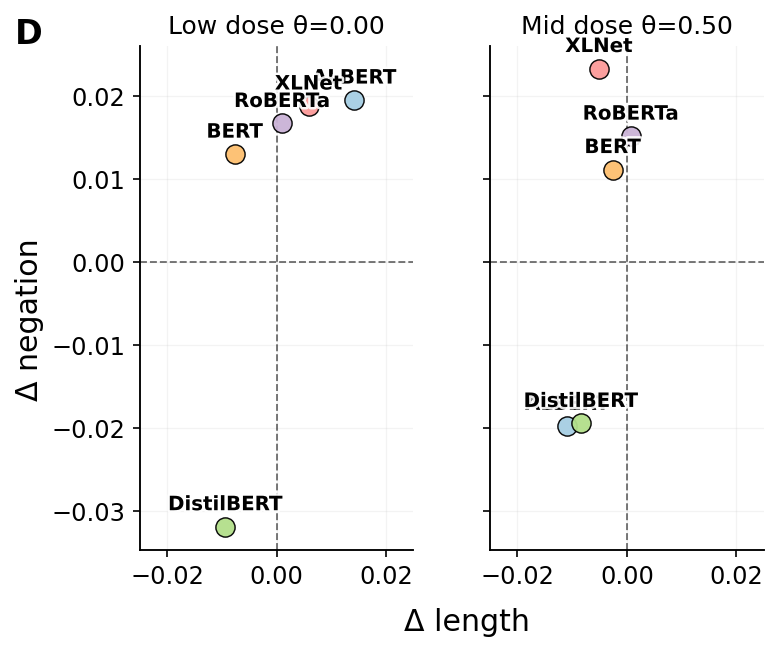

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe

# -------------------------
# Nature-ish styling (MATCH your heatmap/line panel)
# -------------------------
plt.rcParams.update({
    "font.family": "DejaVu Sans",
    "font.size": 12,
    "axes.labelsize": 12,
    "axes.titlesize": 12,
    "xtick.labelsize": 11.5,
    "ytick.labelsize": 11.5,
    "axes.linewidth": 0.9,
    "axes.spines.top": False,
    "axes.spines.right": False,
})

# -------------------------
# Color map = same as violin fills (order-consistent)
# Prefer reusing `models` from your heatmap code if it exists.
# -------------------------
violin_colors = ["#A6CEE3", "#FDBF6F", "#B2DF8A", "#CAB2D6", "#FB9A99"]

if "models" in globals():
    model_order = list(models)
else:
    model_order = sorted(df["TargetModel"].unique())

color_map = {m: violin_colors[i % len(violin_colors)] for i, m in enumerate(model_order)}

# -------------------------
# Plot helper
# -------------------------
def plot_context_scatter(scatter_df: pd.DataFrame, ax, title: str, panel_label: str = ""):
    # subtle grid
    ax.grid(True, which="major", linewidth=0.6, alpha=0.15)
    ax.set_axisbelow(True)

    # quadrant reference
    ax.axhline(0.0, color="black", linewidth=0.9, linestyle="--", alpha=0.55, zorder=1)
    ax.axvline(0.0, color="black", linewidth=0.9, linestyle="--", alpha=0.55, zorder=1)

    # scatter + label (with white stroke for readability)
    for row in scatter_df.itertuples(index=False):
        x = getattr(row, "Delta_length")
        y = getattr(row, "Delta_negation")
        m = getattr(row, "TargetModel")

        if np.isnan(x) or np.isnan(y):
            continue

        c = color_map.get(m, "#999999")
        ax.scatter(
            x, y,
            s=85,
            color=c,
            edgecolor="black",
            linewidth=0.7,
            alpha=0.95,
            zorder=3
        )
        ax.annotate(
            m,
            (x, y),
            xytext=(0, 6),
            textcoords="offset points",
            ha="center",
            va="bottom",
            fontsize=9.5,
            fontweight="bold",
            color="black",
            path_effects=[pe.withStroke(linewidth=2.4, foreground="white", alpha=0.9)],
            zorder=4
        )

    ax.set_title(title, pad=6)

        
def context_mean_disagreement(df_in, model_name, context_type, context_label, dose):
    sub = df_in[
        (df_in["TargetModel"] == model_name)
        & (df_in["ContextType"] == context_type)
        & (df_in["ContextLabel"] == context_label)
        & (np.isclose(df_in["Dose"], dose))
    ]
    if sub.empty:
        return np.nan
    return float(sub["MeanDisagreement"].mean())


def build_scatter_df_for_dose(df_in, dose):
    """
    Build a scatter dataframe for a given dose:
      Delta_length  = D(long) - D(medium)
      Delta_negation = D(has_negation) - D(no_negation)
    """
    length_long = "len_long_(>15)"
    length_medium = "len_medium_(8-15)"
    neg_has = "has_negation"
    neg_no = "no_negation"

    rows = []
    for m in sorted(df_in["TargetModel"].unique()):
        d_long = context_mean_disagreement(df_in, m, "length", length_long, dose)
        d_medium = context_mean_disagreement(df_in, m, "length", length_medium, dose)
        d_has = context_mean_disagreement(df_in, m, "negation", neg_has, dose)
        d_no = context_mean_disagreement(df_in, m, "negation", neg_no, dose)

        rows.append({
            "TargetModel": m,
            "Dose": dose,
            "D_long": d_long,
            "D_medium": d_medium,
            "D_has_neg": d_has,
            "D_no_neg": d_no,
            "Delta_length": d_long - d_medium,
            "Delta_negation": d_has - d_no,
        })
    return pd.DataFrame(rows)


# -------------------------
# Build low/high scatter dataframes (your existing code)
# -------------------------
low_dose = float(df["Dose"].min())
# high_dose = float(df["Dose"].max())
high_dose = 0.5

scatter_low = build_scatter_df_for_dose(df, low_dose)
scatter_high = build_scatter_df_for_dose(df, high_dose)

# -------------------------
# Figure (TOTAL size = 5.2 x 5.2)
# -------------------------
# ---- Figure (TOTAL size = 5.2 x 5.2), but keep axes big ----
fig, axes = plt.subplots(
    1, 2,
    figsize=(5.2, 4.8),
    sharex=True, sharey=True
)

axes[0].set_xlim(-0.025, 0.025)
axes[1].set_xlim(-0.025, 0.025)

plot_context_scatter(scatter_low,  ax=axes[0], title=f"Low dose θ={low_dose:.2f}")
plot_context_scatter(scatter_high, ax=axes[1], title=f"Mid dose θ={high_dose:.2f}")


# common labels (keep them INSIDE the 5.2x5.2 canvas)
fig.supxlabel("Δ length", x=0.6, y=0.06)               
fig.supylabel("Δ negation", x=0.02, rotation=90) 

fig.text(0.02, 0.92, "D", fontsize=16, fontweight="bold", va="top", ha="left")

# manual layout: maximize subplot area (Nature-like)
fig.subplots_adjust(left=0.18, right=0.98, bottom=0.18, top=0.88, wspace=0.28)

# IMPORTANT: do NOT use bbox_inches="tight" if you want the physical size to stay 5.2×5.2
plt.savefig(os.path.join(FIG_PATH, "context_scatter_low_high_nature_square.pdf"), bbox_inches=None)
plt.show()


## Figure – Context-driven disagreement scatter at high dose

**Description.**  
Each point represents one model in a 2D space defined by context-wise disagreement at the highest dose:

- The x-axis (Δ_length) measures how much more the model disagrees with its peers on long sentences than on medium-length sentences.
- The y-axis (Δ_negation) measures how much more the model disagrees on sentences with explicit negation than on sentences without negation.

Points above zero on each axis indicate that the corresponding context (long or negated) amplifies disagreement with peers.

**Key pattern.**

- DistilBERT lies in the upper-right quadrant: it disagrees more with its peers on both long and negated sentences.  
  This matches our DISCO analysis, where DistilBERT becomes the most unique model under heavy corruption for these difficult contexts.
- ALBERT lies in the lower-left quadrant: it disagrees *less* with its peers on long and negated sentences than on medium and non-negated sentences.  
  This supports the view that ALBERT's uniqueness is concentrated on simpler inputs, and that it collapses toward more average behaviour on hard, heavily masked contexts.
- BERT, RoBERTa, and XLNet cluster closer to the origin.  
  Their disagreement profiles are more balanced, with weaker asymmetries between long vs medium and negated vs non-negated sentences.  
  This is consistent with them being easier to approximate by convex combinations of peers across semantic contexts.


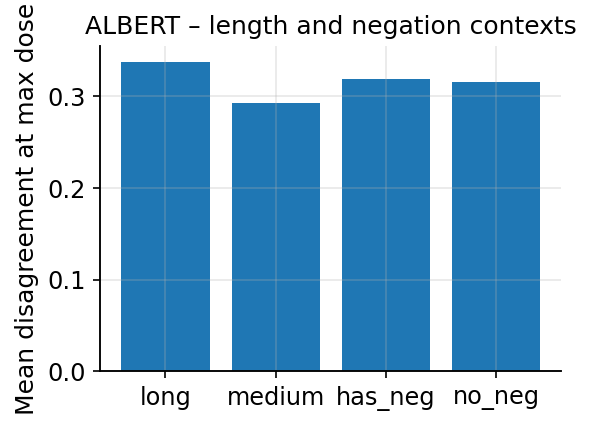

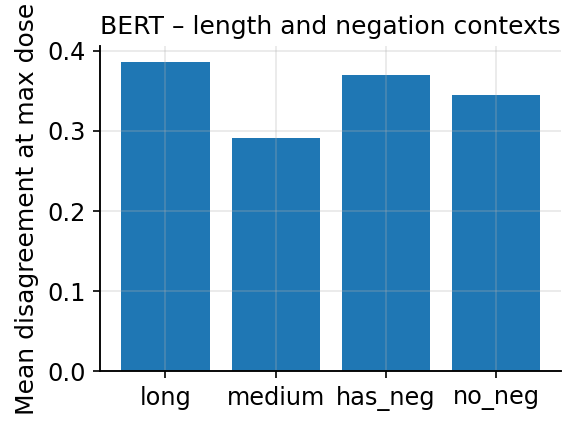

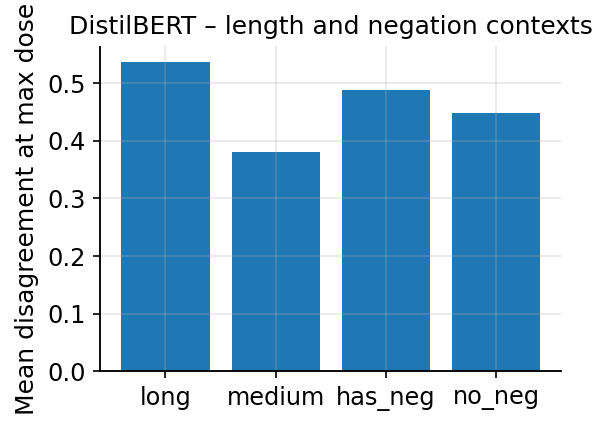

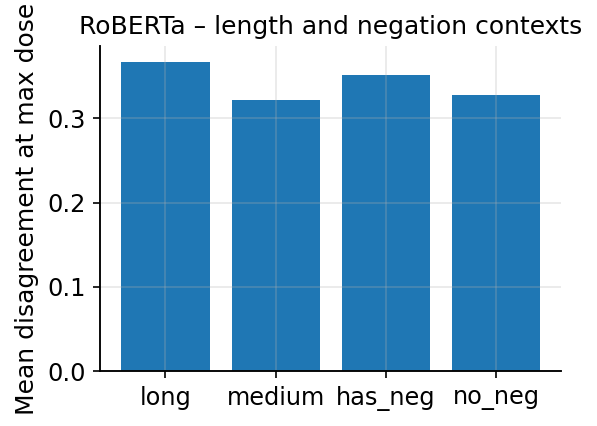

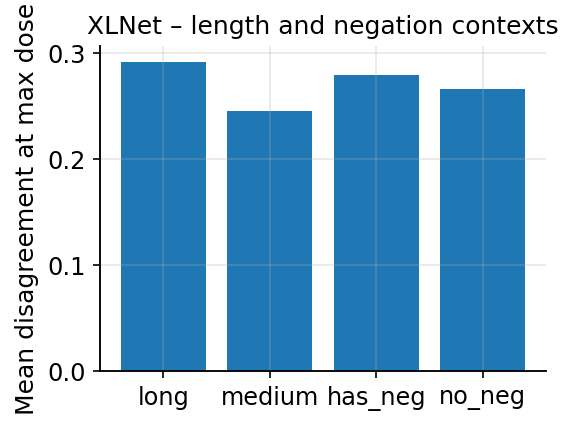

In [5]:
def plot_bar_length_negation_for_model(scatter_df: pd.DataFrame, model_name: str):
    """
    Simple bar plot of D_long, D_medium, D_has_neg, D_no_neg for one model.
    """
    sub = scatter_df[scatter_df["TargetModel"] == model_name]
    if sub.empty:
        print(f"No data for model {model_name}")
        return

    row = sub.iloc[0]
    values = [
        row["D_long"],
        row["D_medium"],
        row["D_has_neg"],
        row["D_no_neg"],
    ]
    labels = ["long", "medium", "has_neg", "no_neg"]

    plt.figure()
    x = np.arange(len(labels))
    plt.bar(x, values)
    plt.xticks(x, labels)
    plt.ylabel("Mean disagreement at max dose")
    plt.title(f"{model_name} – length and negation contexts")
    plt.tight_layout()
    plt.show()


for m in scatter_df["TargetModel"].unique():
    plot_bar_length_negation_for_model(scatter_df, m)


In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load Exp 7 context-wise disagreement summary
exp7_path = os.path.join("..", "results", "tables", "exp7_bert_context_disagreement.csv")
df7 = pd.read_csv(exp7_path)
df7.head()


,ContextType,ContextLabel,TargetModel,Dose,MeanDisagreement,StdDisagreement,NumPoints,ContextRawSize
0,length,len_long_(>15),BERT,0.0,0.156301,0.118986,200,561
1,length,len_long_(>15),BERT,0.1,0.164920,0.108937,200,561
2,length,len_long_(>15),BERT,0.2,0.182434,0.121824,200,561
3,length,len_long_(>15),BERT,0.3,0.255845,0.072204,200,561
4,length,len_long_(>15),BERT,0.4,0.274672,0.105487,200,561


In [ ]:
def compute_global_disagreement(df: pd.DataFrame) -> pd.DataFrame:
    """
    Compute a global disagreement curve for each model and dose:

        mean = weighted mean over contexts of MeanDisagreement (weights=NumPoints)
        std  = weighted std over contexts of MeanDisagreement (same weights)

    Here MeanDisagreement is already averaged within each context bucket,
    so this aggregates across context buckets only.
    """
    rows = []
    for (model, dose), sub in df.groupby(["TargetModel", "Dose"]):
        w = sub["NumPoints"].astype(float).to_numpy()
        v = sub["MeanDisagreement"].astype(float).to_numpy()

        # drop invalid
        mask = np.isfinite(w) & np.isfinite(v) & (w > 0)
        w, v = w[mask], v[mask]
        if w.size == 0 or w.sum() <= 0:
            continue

        wsum = w.sum()
        mean = float(np.sum(w * v) / wsum)

        # weighted std (population form)
        var = float(np.sum(w * (v - mean) ** 2) / wsum)
        std = float(np.sqrt(var))

        rows.append({
            "TargetModel": model,
            "Dose": float(dose),
            "GlobalDisagreement": mean,
            "GlobalDisagreementStd": std,
        })
    return pd.DataFrame(rows)


global_dis = compute_global_disagreement(df7)
global_dis.sort_values(["TargetModel", "Dose"]).head()


,TargetModel,Dose,GlobalDisagreement,GlobalDisagreementStd
0,ALBERT,0.0,0.163381,0.019075
1,ALBERT,0.1,0.170653,0.016814
2,ALBERT,0.2,0.189083,0.016436
3,ALBERT,0.3,0.324166,0.029670
4,ALBERT,0.4,0.349118,0.019176


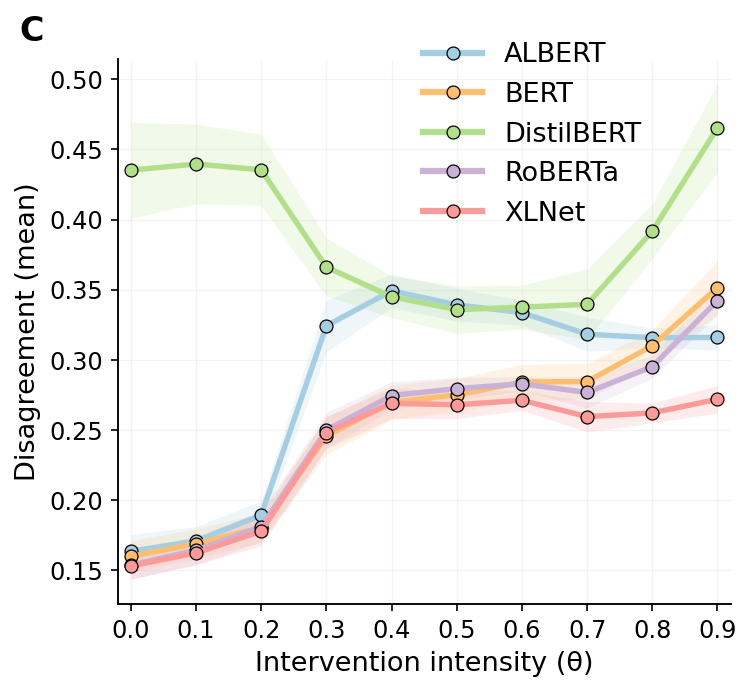

In [59]:
import numpy as np
import matplotlib.pyplot as plt

def plot_global_disagreement(global_df: pd.DataFrame):
    """
    Plot G_t(theta): global mean peer-wise disagreement vs dose (Exp 7),
    styled to MATCH the Nature-style dose curves panel.
    """
    # ---- Styling (match your line-plot panel exactly) ----
    plt.rcParams.update({
        "font.family": "DejaVu Sans",
        "font.size": 13,
        "axes.labelsize": 13,
        "axes.titlesize": 13,
        "xtick.labelsize": 11.5,
        "ytick.labelsize": 11.5,
        "axes.linewidth": 0.9,
        "axes.spines.top": False,
        "axes.spines.right": False,
    })

    # --- figure size consistent with your panels ---
    fig, ax = plt.subplots(figsize=(5.2, 4.8))

    # subtle grid
    ax.grid(True, which="major", linewidth=0.6, alpha=0.15)
    ax.set_axisbelow(True)

    # --- color map: match violin colors / heatmap model order if available ---
    violin_colors = ["#A6CEE3", "#FDBF6F", "#B2DF8A", "#CAB2D6", "#FB9A99"]
    if "models" in globals():
        model_order = list(models)
    else:
        model_order = sorted(global_df["TargetModel"].unique())
    color_map = {m: violin_colors[i % len(violin_colors)] for i, m in enumerate(model_order)}

    # --- plot ---
    for model in model_order:
        sub = global_df[global_df["TargetModel"] == model].sort_values("Dose")
        if sub.empty:
            continue
        doses = sub["Dose"].values
        errs = sub["GlobalDisagreement"].values
        std = sub["GlobalDisagreementStd"].values
        sem = std / np.sqrt(len(doses))

        ax.plot(
            doses, errs,
            linewidth=2.6,
            marker="o",
            markersize=6.2,
            color=color_map.get(model, "#333333"),
            markeredgecolor="black",
            markeredgewidth=0.6,
            label=model,
            zorder=3
        )
        ax.fill_between(doses, errs-1.96*sem, errs+1.96*sem, alpha=0.18, linewidth=0, color=color_map[model], zorder=1)

    # labels (short, Nature-ish)
    ax.set_xlabel("Intervention intensity (θ)")
    ax.set_ylabel("Disagreement (mean)")

    # x ticks (use unique doses)
    thetas = np.array(sorted(global_df["Dose"].unique()))
    ax.set_xticks(thetas)
    ax.set_xlim(thetas.min() - 0.02, thetas.max() + 0.02)

    # legend (inside, clean) + thicker handles
    leg = ax.legend(
        frameon=False,
        loc="upper left",
        bbox_to_anchor=(0.48, 1.05),
        borderaxespad=0.0,
        handlelength=2.2
    )
    handles = getattr(leg, "legend_handles", None)
    if handles is None:
        handles = getattr(leg, "legendHandles", None)
    if handles is None:
        handles = leg.get_lines()
    for h in handles:
        try:
            h.set_linewidth(3.0)
        except Exception:
            pass
        
    # panel label (optional)
    ax.text(-0.16, 1.02, "C", transform=ax.transAxes, fontsize=16, fontweight="bold", va="bottom")
    
    # manual layout: maximize subplot area (Nature-like)
    fig.subplots_adjust(left=0.18, right=0.98, bottom=0.18, top=0.88, wspace=0.28)
    
    plt.savefig(os.path.join(FIG_PATH, "dose_curves_disagreement.pdf"), bbox_inches=None)

    plt.tight_layout()
    plt.show()



plot_global_disagreement(global_dis)
